In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Download the dataset

In [2]:
!gdown 1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt

Downloading...
From: https://drive.google.com/uc?id=1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt
To: /content/Twitter_Data.csv
100% 20.9M/20.9M [00:00<00:00, 104MB/s]


In [3]:
df = pd.read_csv('/content/Twitter_Data.csv')
df.info()
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


In [4]:
# Fix Missing data
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


# Checking for RAM

In [5]:
import psutil

# Function to check RAM usage
def check_ram():
    memory = psutil.virtual_memory()
    total_ram = memory.total / (1024 ** 3)  # Convert bytes to GB
    used_ram = memory.used / (1024 ** 3)
    available_ram = memory.available / (1024 ** 3)
    print(f"Total RAM: {total_ram:.2f} GB")
    print(f"Used RAM: {used_ram:.2f} GB")
    print(f"Available RAM: {available_ram:.2f} GB")

In [6]:
check_ram()

Total RAM: 12.67 GB
Used RAM: 1.13 GB
Available RAM: 11.23 GB


# Proccess -> Create X and y

In [7]:
# Normalize text
def text_normalize(text):
  text = text.lower()
  text = re.sub(r'^rt[\s]+', '', text)
  text = re.sub(r'https ?:\/\/.*[\ r\n]*', '', text )
  text = re.sub(r'[^\w\s]', '', text)

  stop_words = set ( stopwords.words('english'))

  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  words = text.split()
  stemmer = SnowballStemmer('english')
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)

  return text

In [8]:
proccessed_texts = [text_normalize(text) for text in df['clean_text'].values]

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(proccessed_texts) # numpy now
y = df['category'].values

In [10]:
check_ram()

Total RAM: 12.67 GB
Used RAM: 1.50 GB
Available RAM: 10.86 GB


# We have X, y now. But...

In [13]:
print(f"Type of X: {type(X)}")
print(f"Shape of X: {X.shape}")
print(f"Type of y: {type(y)}")
print(f"Shape of y: {y.shape}")

Type of X: <class 'scipy.sparse._csr.csr_matrix'>
Shape of X: (162969, 88410)
Type of y: <class 'numpy.ndarray'>
Shape of y: (162969,)


Add bias to X

In [17]:
bias = np.ones((X.shape[0], 1))
bias = csr_matrix(bias)
X = hstack([bias, X])

Add one to y

In [15]:
print(np.unique(y)) # -1 0 1
# We add 1 to the y
y = y + 1
print(np.unique(y)) # 0 1 2

[-1.  0.  1.]
[0. 1. 2.]


One hot encoding y

In [22]:
n_samples = X.shape[0]
n_classes = np.unique(y).shape[0]
y_one_hot = np.zeros((n_samples, n_classes))
y_one_hot[np.arange(n_samples), y.astype(np.uint8)] = 1

# Train test split

In [24]:
val_to_train = 0.2
test_to_val = 0.1
random_state = 2

X_train, X_val, y_train, y_val = train_test_split(
    X, y_one_hot,
    test_size=val_to_train,
    shuffle=True,
    random_state=random_state
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=test_to_val,
    shuffle=True,
    random_state=random_state
)

# We can train now

Some function

In [32]:
def softmax(z):
  exp_z = np.exp(z)

  return exp_z / np.sum(exp_z, axis=1)[:, None]

def compute_loss(y_hat, y):
  n = y.size

  return (-1/n) * np.sum(y * np.log(y_hat))

def predict(X, theta):
  z = X @ theta # sparse matrix
  return softmax(z)

def compute_gradient(X, y, y_hat):
  n = y.size

  return X.T.dot(y_hat - y) / n

def update_theta(theta, gradient, learning_rate):
  return theta - learning_rate * gradient

def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta)
  acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
  return acc


In [47]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]
np.random.seed (random_state)
theta = np.random.uniform(
  size =(n_features, n_classes)
)

In [48]:
# Start training
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  b_train_losses = []
  b_train_accs = []
  b_val_losses = []
  b_val_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_batch = X_train[i:i+batch_size, :]
    y_batch = y_train[i:i+batch_size, :]

    y_hat = predict(X_batch, theta)

    loss = compute_loss(y_hat, y_batch)

    gradient = compute_gradient(X_batch, y_batch, y_hat)

    theta = update_theta(theta, gradient, lr)

    # Update log
    # train
    b_train_losses.append(loss)
    train_acc = compute_accuracy(X_batch, y_batch, theta)
    b_train_accs.append(train_acc)

    # val
    val_y_hat = predict(X_val, theta)
    val_loss = compute_loss(val_y_hat, y_val)
    val_acc = compute_accuracy(X_val, y_val, theta)
    b_val_losses.append(val_loss)
    b_val_accs.append(val_acc)

  b_train_mean_loss = sum(b_train_losses) / len(b_train_losses)
  b_train_mean_acc = sum(b_train_accs) / len(b_train_accs)
  b_val_mean_loss = sum(b_val_losses) / len(b_val_losses)
  b_val_mean_acc = sum(b_val_accs) / len(b_val_accs)

  train_accs.append(b_train_mean_acc)
  train_losses.append(b_train_mean_loss)
  val_accs.append(b_val_mean_acc)
  val_losses.append(b_val_mean_loss)

  print (f'\nEPOCH { epoch + 1}:\tTraining loss : { b_train_mean_loss:.3f}\tValidation loss : { b_val_mean_loss:.3f}')



EPOCH 1:	Training loss : 0.385	Validation loss : 0.384

EPOCH 2:	Training loss : 0.384	Validation loss : 0.383

EPOCH 3:	Training loss : 0.384	Validation loss : 0.383

EPOCH 4:	Training loss : 0.384	Validation loss : 0.382

EPOCH 5:	Training loss : 0.383	Validation loss : 0.382

EPOCH 6:	Training loss : 0.383	Validation loss : 0.382

EPOCH 7:	Training loss : 0.383	Validation loss : 0.381

EPOCH 8:	Training loss : 0.382	Validation loss : 0.381

EPOCH 9:	Training loss : 0.382	Validation loss : 0.381

EPOCH 10:	Training loss : 0.382	Validation loss : 0.380

EPOCH 11:	Training loss : 0.381	Validation loss : 0.380

EPOCH 12:	Training loss : 0.381	Validation loss : 0.380

EPOCH 13:	Training loss : 0.381	Validation loss : 0.380

EPOCH 14:	Training loss : 0.380	Validation loss : 0.379

EPOCH 15:	Training loss : 0.380	Validation loss : 0.379

EPOCH 16:	Training loss : 0.380	Validation loss : 0.379

EPOCH 17:	Training loss : 0.380	Validation loss : 0.378

EPOCH 18:	Training loss : 0.379	Validat

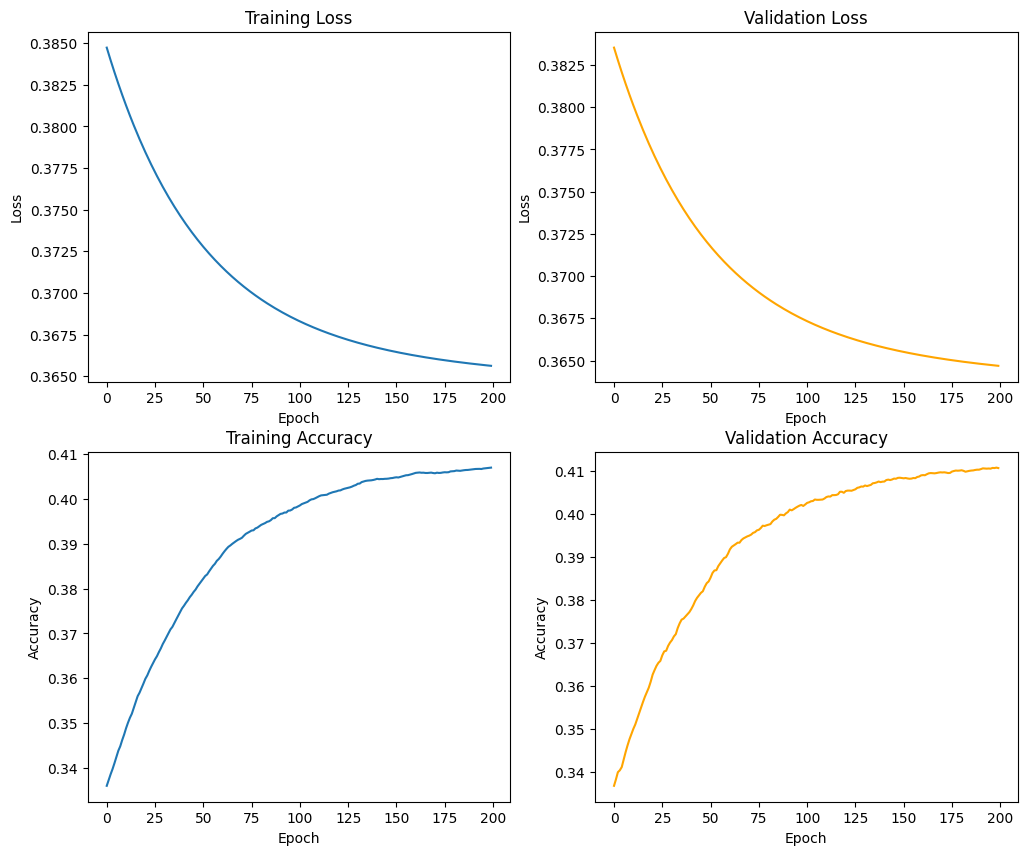

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set_title('Validation Accuracy')

# Set common labels
for i in range(2):
    ax[0, i].set(xlabel='Epoch', ylabel='Loss')
    ax[1, i].set(xlabel='Epoch', ylabel='Accuracy')

plt.show()

In [50]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation Set Accuracy: {val_set_acc}')
print(f'Test Set Accuracy: {test_set_acc}')


Evaluation on validation and test set:
Validation Set Accuracy: 0.41071793822867664
Test Set Accuracy: 0.4110429447852761
